#Data loading and visualization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from glob import glob
from skimage.io import imread

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

import time
import copy
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print('Imports complete')


Imports complete


In [ ]:
# Model Parameters
num_epochs = 10
batch_size = 128
num_classes = 2
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
base_dir= '/content/drive/MyDrive/PRML project/'
print(os.listdir(base_dir))

['train_labels.csv', 'sample_submission.csv', 'histopathologic-cancer-detection.zip', 'test', 'train', 'project_vanilla.ipynb', 'Random_Sample', 'StratifiedSampling.ipynb', 'prml_project_base.ipynb', 'Project Vanilla.ipynb', 'model.ckpt', 'model_sampled.ckpt', 'ExploratoryDataAnalysis.ipynb']


In [ ]:
!unzip '/content/drive/MyDrive/PRML project/histopathologic-cancer-detection.zip' > /dev/null

In [ ]:
train_path = '/content/train'
test_path = '/content/test'
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

In [ ]:
labels = pd.read_csv('/content/'+ "train_labels.csv")
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
labels.shape

(220025, 2)

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
train_files[:5]

['bdd489ed1ac9390a59cb5d56f6f7155c2d442a9f.tif',
 '3299922c575dfdd35065ff6a2e3916c9fba7ad4d.tif',
 'f765ff5b0de5a1bd3e6aea11ad20c56e749da4e6.tif',
 '7328fa8c2e5aa168b34e3398eb5a1733bc0e64b9.tif',
 '607d052995dfa1d2663c177f2f2b97b85521eb6a.tif']

In [ ]:
test_files[:5]

['982c97dfcf52ca850c42120d58ea4585d884b612.tif',
 '6d16f29d6f13c9e6e49977a747ecb5dcf6b148d3.tif',
 'a042468a556b57ca2cea402ef383d38821a0c417.tif',
 '003d14ca5481028a008c34b6cca7c235dcc1d298.tif',
 '4dcf588f36f3af731771d9ac63b3887d750b095f.tif']

In [ ]:
print("Train size: ", len(train_files))
print("Test size: ", len(test_files))

Train size:  220025
Test size:  57458


In [ ]:
print((len(train_files)/(len(train_files)+len(test_files)))*100, (len(test_files)/(len(train_files)+len(test_files)))*100)

79.29314588641466 20.706854113585337


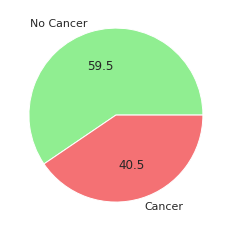

In [ ]:
plt.pie(labels.label.value_counts(), labels=['No Cancer', 'Cancer'], colors=['#90EE91', '#F47174'], autopct='%1.1f')
plt.show()

In [ ]:
labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [ ]:
positive_images = np.random.choice(labels[labels.label==1].id, size=50, replace=False)
negative_images = np.random.choice(labels[labels.label==0].id, size=50, replace=False)

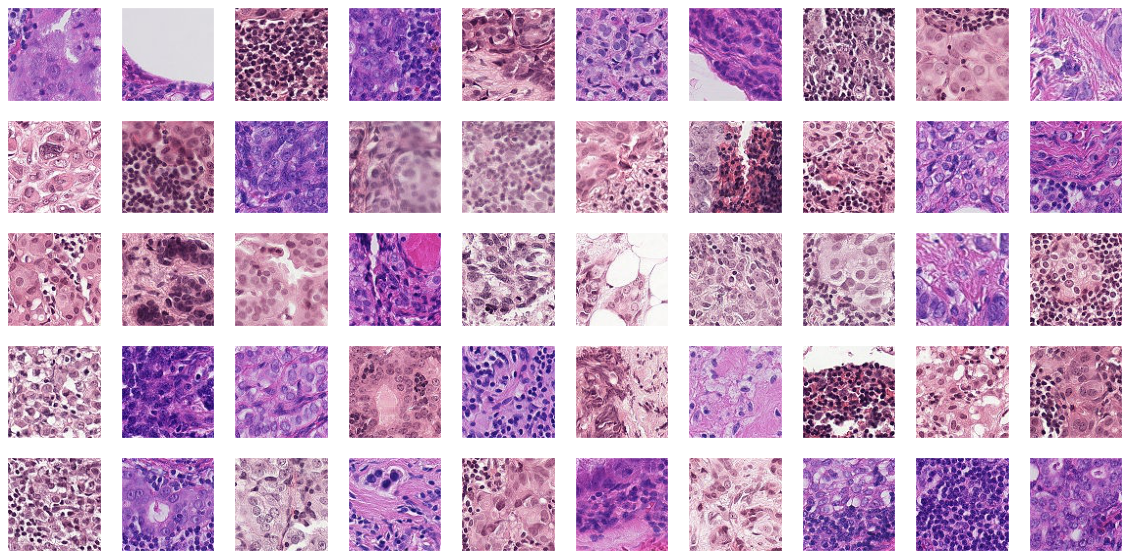

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = positive_images[m + n*10]
        image = Image.open(train_path+"/" + img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

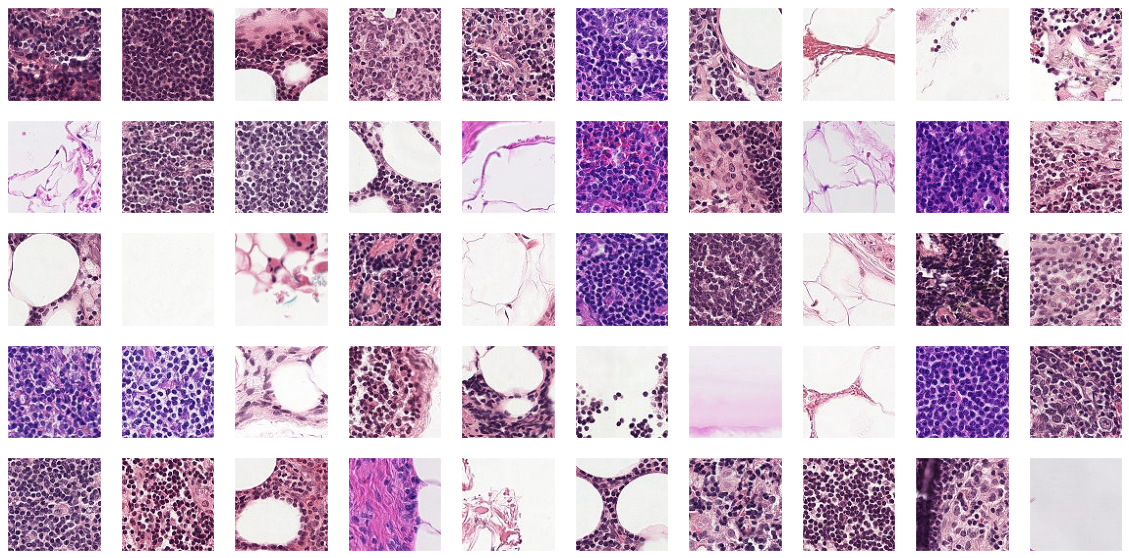

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = negative_images[m + n*10]
        image = Image.open(train_path +"/"+ img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

#Vanilla

##v0.0

###Data and dataset

In [ ]:

train_data= train_files
test_data= test_files

In [ ]:
train, val = train_test_split(labels, stratify=labels.label, test_size=0.1)
len(train), len(val)

(198022, 22003)

In [ ]:
class Dataset(Dataset):
    def __init__(self, data_df, data_dir = './', transform=None):
        super().__init__()
        self.df = data_df.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

###Image processing

In [ ]:
batch_size = 128
valid_size = 0.1

path='/content/train/'

In [ ]:
trans_train = transforms.Compose([transforms.ToPILImage(),                   
                                  transforms.Pad(64, padding_mode='reflect'),   
                                  transforms.RandomHorizontalFlip(),            
                                  transforms.RandomVerticalFlip(),            
                                  transforms.RandomRotation(20),             
                                  transforms.ToTensor(),                     
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])    

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = Dataset(data_df=train, data_dir=path, transform=trans_train)
dataset_valid = Dataset(data_df=val, data_dir=path, transform=trans_valid)

train_loader = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

###Model definition

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNor

In [ ]:
'''optimization and loss function'''
criterion = nn.CrossEntropyLoss()

learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
num_epochs = 10
total_step = len(train_loader)
for epoch in range(num_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        
        train_loss = train_loss/len(train_loader.sampler)
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/1548], Loss: 0.4026
Epoch [1/10], Step [200/1548], Loss: 0.3613
Epoch [1/10], Step [300/1548], Loss: 0.3181
Epoch [1/10], Step [400/1548], Loss: 0.4017
Epoch [1/10], Step [500/1548], Loss: 0.4052
Epoch [1/10], Step [600/1548], Loss: 0.2707
Epoch [1/10], Step [700/1548], Loss: 0.2811
Epoch [1/10], Step [800/1548], Loss: 0.2954
Epoch [1/10], Step [900/1548], Loss: 0.2563
Epoch [1/10], Step [1000/1548], Loss: 0.2082
Epoch [1/10], Step [1100/1548], Loss: 0.4034
Epoch [1/10], Step [1200/1548], Loss: 0.2589
Epoch [1/10], Step [1300/1548], Loss: 0.3061
Epoch [1/10], Step [1400/1548], Loss: 0.3613
Epoch [1/10], Step [1500/1548], Loss: 0.2976
Epoch [2/10], Step [100/1548], Loss: 0.2880
Epoch [2/10], Step [200/1548], Loss: 0.1942
Epoch [2/10], Step [300/1548], Loss: 0.2789
Epoch [2/10], Step [400/1548], Loss: 0.2929
Epoch [2/10], Step [500/1548], Loss: 0.1911
Epoch [2/10], Step [600/1548], Loss: 0.2431
Epoch [2/10], Step [700/1548], Loss: 0.2099
Epoch [2/10], Step [800/15

###Testing

In [ ]:
model = CNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/PRML project/model.ckpt'))  # Choose whatever GPU device number you want
model.to(device)
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 22003 test images: {} %'.format(100 * correct / total))




Test Accuracy of the model on the 22003 test images: 94.64618461118938 %


##v0.1